# DINOv3 + U-Net for Glacier-Constrained Lake Segmentation

This notebook implements lake detection constrained to glacier boundaries:
1. Load satellite imagery and glacier shapefile
2. Create glacier mask from shapefile
3. Sample training patches only within glacier areas
4. Train DINOv3+U-Net model on glacier-constrained data
5. Apply predictions only within glacier boundaries

**Key improvement:** Eliminates irrelevant terrain outside glaciers for better training and results.

## Step 1: Setup and Imports

In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import rasterio.mask

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# DINOv3
from transformers import AutoModel
from huggingface_hub import login

# Login (you already have this)
login(token="login-token")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/Users/varyabazilova/opt/anaconda3/envs/superlakes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Step 2: Load Data and Create Glacier Mask

In [2]:
# File paths
image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_testclip2.tif"
mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask_testclip2.tif"
glacier_shp_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/clip_by_glacier.shp"

# Load satellite image and lake mask
with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (channels, height, width)
    image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)
    image_transform = src.transform
    image_crs = src.crs
    
with rasterio.open(mask_path) as src:
    lake_mask = src.read(1)  # Read first band

print(f"Image shape: {image.shape}")
print(f"Lake mask shape: {lake_mask.shape}")
print(f"Image CRS: {image_crs}")

# Convert to working formats
image_rgb = image[:,:,:3].astype(np.uint8)  # Take only RGB channels
lake_mask_binary = (lake_mask > 0).astype(np.float32)  # Binary lake mask

print(f"RGB image shape: {image_rgb.shape}")
print(f"RGB image range: {image_rgb.min()} - {image_rgb.max()}")

Image shape: (4673, 1362, 4)
Lake mask shape: (4673, 1362)
Image CRS: EPSG:32645
RGB image shape: (4673, 1362, 3)
RGB image range: 70 - 255


In [3]:

# Create glacier mask from shapefile
def create_glacier_mask(glacier_shp_path, image_shape, image_transform, image_crs, lake_mask=None):
  """
  Create glacier mask from shapefile matching the image grid
  Also calculates lake statistics within glacier boundaries if lake_mask provided
  """
  print("Loading glacier shapefile...")

  # Load glacier shapefile
  glacier_gdf = gpd.read_file(glacier_shp_path)
  print(f"Loaded {len(glacier_gdf)} glacier polygons")
  print(f"Shapefile CRS: {glacier_gdf.crs}")

  # Reproject if needed
  if glacier_gdf.crs != image_crs:
      print(f"Reprojecting from {glacier_gdf.crs} to {image_crs}")
      glacier_gdf = glacier_gdf.to_crs(image_crs)

  # Create glacier mask
  print("Rasterizing glacier polygons...")
  glacier_mask = rasterize(
      [(geom, 1) for geom in glacier_gdf.geometry],
      out_shape=image_shape[:2],
      transform=image_transform,
      fill=0,
      dtype=np.uint8
  )

  # Calculate glacier statistics
  glacier_pixels = glacier_mask.sum()
  total_pixels = glacier_mask.size
  glacier_coverage = glacier_pixels / total_pixels * 100

  print(f"Glacier mask created: {glacier_pixels:,} pixels ({glacier_coverage:.1f}% of image)")

  # Calculate lake statistics within glacier if lake mask provided
  if lake_mask is not None:
      print("\nCalculating lake statistics within glacier boundaries...")

      # Convert glacier mask to boolean for easier operations
      glacier_bool = glacier_mask.astype(bool)
      lake_bool = (lake_mask > 0).astype(bool)

      # Lake statistics
      total_lake_pixels = lake_bool.sum()
      glacier_lake_pixels = (glacier_bool & lake_bool).sum()

      # Percentages
      lakes_in_glacier_pct = (glacier_lake_pixels / total_lake_pixels * 100) if total_lake_pixels > 0 else 0
      lake_coverage_of_glacier = (glacier_lake_pixels / glacier_pixels * 100) if glacier_pixels > 0 else 0

      print(f"Total lake pixels (entire image): {total_lake_pixels:,}")
      print(f"Lake pixels within glacier: {glacier_lake_pixels:,}")
      print(f"Percentage of lakes within glacier: {lakes_in_glacier_pct:.1f}%")
      print(f"Lake coverage of glacier area: {lake_coverage_of_glacier:.2f}%")

      # Area calculations (assuming 3m pixel resolution)
      pixel_area_m2 = 9  # 3m x 3m = 9 square meters per pixel
      pixel_area_km2 = pixel_area_m2 / 1_000_000  # Convert to km²

      glacier_area_km2 = glacier_pixels * pixel_area_km2
      total_lake_area_km2 = total_lake_pixels * pixel_area_km2
      glacier_lake_area_km2 = glacier_lake_pixels * pixel_area_km2

      print(f"\nArea calculations (assuming 3m pixel resolution):")
      print(f"Total glacier area: {glacier_area_km2:.3f} km²")
      print(f"Total lake area (entire image): {total_lake_area_km2:.3f} km²")
      print(f"Lake area within glacier: {glacier_lake_area_km2:.3f} km²")

      return glacier_mask.astype(bool), {
          'glacier_pixels': glacier_pixels,
          'total_lake_pixels': total_lake_pixels,
          'glacier_lake_pixels': glacier_lake_pixels,
          'lakes_in_glacier_pct': lakes_in_glacier_pct,
          'lake_coverage_of_glacier': lake_coverage_of_glacier,
          'glacier_area_km2': glacier_area_km2,
          'total_lake_area_km2': total_lake_area_km2,
          'glacier_lake_area_km2': glacier_lake_area_km2
      }

  return glacier_mask.astype(bool)

# Create glacier mask with lake statistics
glacier_mask, lake_stats = create_glacier_mask(
  glacier_shp_path, image.shape, image_transform, image_crs,
  lake_mask=lake_mask_binary  # Pass the lake mask for statistics
)

print(f"\nGlacier mask shape: {glacier_mask.shape}")
print(f"Glacier area: {glacier_mask.sum():,} pixels")

# Access the lake statistics
if lake_stats:
  print(f"\nKey Statistics:")
  print(f"• {lake_stats['lakes_in_glacier_pct']:.1f}% of all lakes are within glaciers")
  print(f"• {lake_stats['lake_coverage_of_glacier']:.2f}% of glacier area is lakes")
  print(f"• {lake_stats['glacier_lake_area_km2']:.3f} km² of supraglacial lakes")


Loading glacier shapefile...
Loaded 1 glacier polygons
Shapefile CRS: EPSG:4326
Reprojecting from EPSG:4326 to EPSG:32645
Rasterizing glacier polygons...
Glacier mask created: 1,409,146 pixels (22.1% of image)

Calculating lake statistics within glacier boundaries...
Total lake pixels (entire image): 29,678
Lake pixels within glacier: 29,633
Percentage of lakes within glacier: 99.8%
Lake coverage of glacier area: 2.10%

Area calculations (assuming 3m pixel resolution):
Total glacier area: 12.682 km²
Total lake area (entire image): 0.267 km²
Lake area within glacier: 0.267 km²

Glacier mask shape: (4673, 1362)
Glacier area: 1,409,146 pixels

Key Statistics:
• 99.8% of all lakes are within glaciers
• 2.10% of glacier area is lakes
• 0.267 km² of supraglacial lakes


## Step 3: Visualize Glacier Constraint

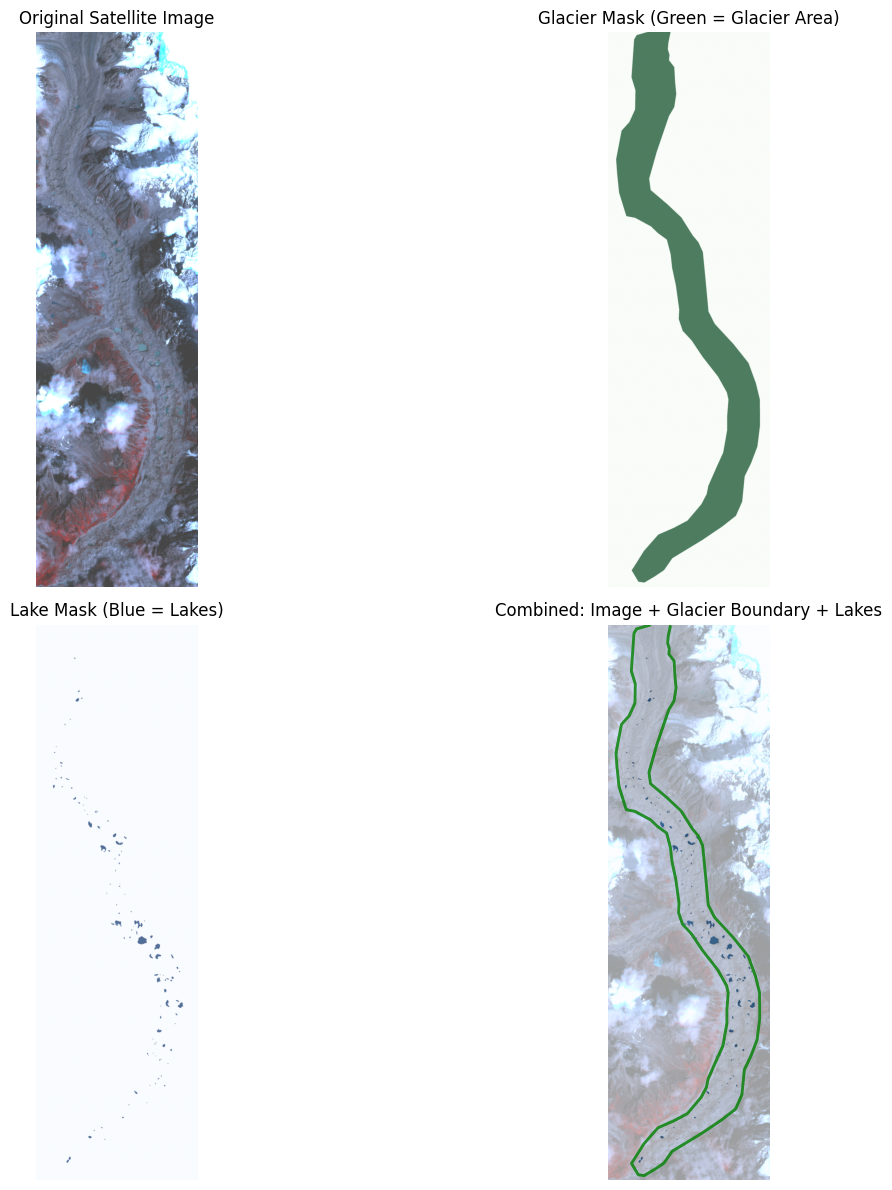


Lake Statistics:
Total lake pixels: 29,678
Lake pixels within glacier: 29,633
Percentage of lakes within glacier: 99.8%


In [4]:
# Visualize glacier masking
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original image
axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('Original Satellite Image')
axes[0, 0].axis('off')

# Glacier mask
axes[0, 1].imshow(glacier_mask, cmap='Greens', alpha=0.7)
axes[0, 1].set_title('Glacier Mask (Green = Glacier Area)')
axes[0, 1].axis('off')

# Lake mask
axes[1, 0].imshow(lake_mask_binary, cmap='Blues', alpha=0.7)
axes[1, 0].set_title('Lake Mask (Blue = Lakes)')
axes[1, 0].axis('off')

# Combined: Image + Glacier boundary + Lakes
axes[1, 1].imshow(image_rgb)
axes[1, 1].contour(glacier_mask, levels=[0.5], colors='green', linewidths=2, alpha=0.8)
axes[1, 1].imshow(lake_mask_binary, cmap='Blues', alpha=0.5)
axes[1, 1].set_title('Combined: Image + Glacier Boundary + Lakes')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Calculate statistics
glacier_lake_pixels = (glacier_mask & (lake_mask_binary > 0)).sum()
total_lake_pixels = (lake_mask_binary > 0).sum()
lakes_in_glacier_pct = glacier_lake_pixels / total_lake_pixels * 100 if total_lake_pixels > 0 else 0

print(f"\nLake Statistics:")
print(f"Total lake pixels: {total_lake_pixels:,}")
print(f"Lake pixels within glacier: {glacier_lake_pixels:,}")
print(f"Percentage of lakes within glacier: {lakes_in_glacier_pct:.1f}%")

## Step 4: Glacier-Constrained Dataset Creation

In [5]:
class GlacierConstrainedDataset(Dataset):
    """
    Dataset that samples patches only within glacier boundaries
    Ensures high-quality training data focused on relevant areas
    """
    def __init__(self, image, lake_mask, glacier_mask, patch_size=65, max_patches=100, lake_ratio=0.7, min_glacier_coverage=0.8):
        self.image = image
        self.lake_mask = lake_mask
        self.glacier_mask = glacier_mask
        self.patch_size = patch_size
        
        # Storage for patches
        self.patches = []
        self.mask_patches = []
        self.patch_info = []
        
        height, width = image.shape[:2]
        
        print("Analyzing glacier-constrained patch locations...")
        
        # Find all potential patches within glacier areas
        glacier_lake_patches = []
        glacier_background_patches = []
        
        step_size = patch_size // 6  # Dense sampling for better coverage
        
        for y in range(0, height - patch_size + 1, step_size):
            for x in range(0, width - patch_size + 1, step_size):
                # Extract masks for this patch
                patch_glacier_mask = glacier_mask[y:y+patch_size, x:x+patch_size]
                patch_lake_mask = lake_mask[y:y+patch_size, x:x+patch_size]
                
                # Calculate coverage statistics
                total_pixels = patch_size * patch_size
                glacier_pixels = patch_glacier_mask.sum()
                lake_pixels = patch_lake_mask.sum()
                
                glacier_coverage = glacier_pixels / total_pixels
                lake_coverage = lake_pixels / total_pixels
                
                # Only consider patches with sufficient glacier coverage
                if glacier_coverage >= min_glacier_coverage:
                    patch_info = {
                        'y': y, 'x': x,
                        'glacier_coverage': glacier_coverage,
                        'lake_coverage': lake_coverage,
                        'glacier_pixels': glacier_pixels,
                        'lake_pixels': lake_pixels
                    }
                    
                    if lake_coverage > 0.005:  # At least 0.5% lake coverage
                        glacier_lake_patches.append(patch_info)
                    else:
                        glacier_background_patches.append(patch_info)
        
        print(f"Found {len(glacier_lake_patches)} glacier patches with lakes")
        print(f"Found {len(glacier_background_patches)} glacier background patches")
        
        # Sort lake patches by lake coverage (most lake-rich first)
        glacier_lake_patches.sort(key=lambda x: x['lake_coverage'], reverse=True)
        
        # Create balanced dataset
        n_lake_patches = min(len(glacier_lake_patches), int(max_patches * lake_ratio))
        n_background_patches = min(len(glacier_background_patches), max_patches - n_lake_patches)
        
        print(f"Selecting {n_lake_patches} glacier patches with lakes")
        print(f"Selecting {n_background_patches} glacier background patches")
        
        # Add lake patches
        for i in range(n_lake_patches):
            patch_info = glacier_lake_patches[i]
            self._add_patch(patch_info)
            
            if i < 5:  # Show details for first few patches
                print(f"  Lake patch {i+1}: {patch_info['lake_coverage']:.1%} lake, {patch_info['glacier_coverage']:.1%} glacier")
        
        # Add background patches (randomly sampled)
        import random
        random.shuffle(glacier_background_patches)
        for i in range(n_background_patches):
            patch_info = glacier_background_patches[i]
            self._add_patch(patch_info)
        
        print(f"\nFinal dataset: {len(self.patches)} patches")
        
        # Calculate dataset statistics
        total_lake_pixels = sum(info['lake_pixels'] for info in self.patch_info)
        total_glacier_pixels = sum(info['glacier_pixels'] for info in self.patch_info)
        total_pixels = len(self.patches) * patch_size * patch_size
        
        print(f"Dataset lake coverage: {total_lake_pixels/total_pixels:.1%}")
        print(f"Dataset glacier coverage: {total_glacier_pixels/total_pixels:.1%}")
        
        # Data transforms - resize to 224x224 for DINOv3
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),  # Resize to DINOv3 input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Mask transform - resize to 224x224 to match DINOv3 output, then will be resized back to patch_size
        self.mask_transform = transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)
    
    def _add_patch(self, patch_info):
        """Add a patch to the dataset"""
        y, x = patch_info['y'], patch_info['x']
        
        # Extract image and mask patches
        img_patch = self.image[y:y+self.patch_size, x:x+self.patch_size]
        mask_patch = self.lake_mask[y:y+self.patch_size, x:x+self.patch_size]
        glacier_patch = self.glacier_mask[y:y+self.patch_size, x:x+self.patch_size]
        
        # Zero out non-glacier areas (focus training on glacier regions)
        img_patch = img_patch.copy()
        mask_patch = mask_patch.copy()
        
        # Set non-glacier pixels to black in image and no-lake in mask
        img_patch[~glacier_patch] = 0
        mask_patch[~glacier_patch] = 0
        
        self.patches.append(img_patch)
        self.mask_patches.append(mask_patch)
        self.patch_info.append(patch_info)
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        image_patch = self.patches[idx]
        mask_patch = self.mask_patches[idx]
        
        # Transform image (resize to 224x224 for DINOv3)
        image_tensor = self.transform(image_patch)
        
        # Transform mask (resize to 224x224, then convert to tensor)
        mask_pil = Image.fromarray((mask_patch * 255).astype(np.uint8))
        mask_resized = self.mask_transform(mask_pil)
        mask_tensor = transforms.ToTensor()(mask_resized)
        
        return image_tensor, mask_tensor

# Create glacier-constrained dataset with 20x20 patches
print("Creating glacier-constrained dataset with 20x20 patches...")
glacier_dataset = GlacierConstrainedDataset(
    image_rgb, lake_mask_binary, glacier_mask,
    patch_size=20,  # Changed to 20x20 for small lakes
    max_patches=100,
    lake_ratio=0.7,  # 70% patches with lakes
    min_glacier_coverage=0.6  # Patches must be 60% glacier
)

glacier_dataloader = DataLoader(glacier_dataset, batch_size=4, shuffle=True)

Creating glacier-constrained dataset with 20x20 patches...
Analyzing glacier-constrained patch locations...
Found 14409 glacier patches with lakes
Found 139836 glacier background patches
Selecting 70 glacier patches with lakes
Selecting 30 glacier background patches
  Lake patch 1: 100.0% lake, 100.0% glacier
  Lake patch 2: 100.0% lake, 100.0% glacier
  Lake patch 3: 100.0% lake, 100.0% glacier
  Lake patch 4: 100.0% lake, 100.0% glacier
  Lake patch 5: 100.0% lake, 100.0% glacier

Final dataset: 100 patches
Dataset lake coverage: 70.0%
Dataset glacier coverage: 99.8%


## Step 5: Visualize Glacier-Constrained Dataset

Visualizing glacier-constrained dataset patches...


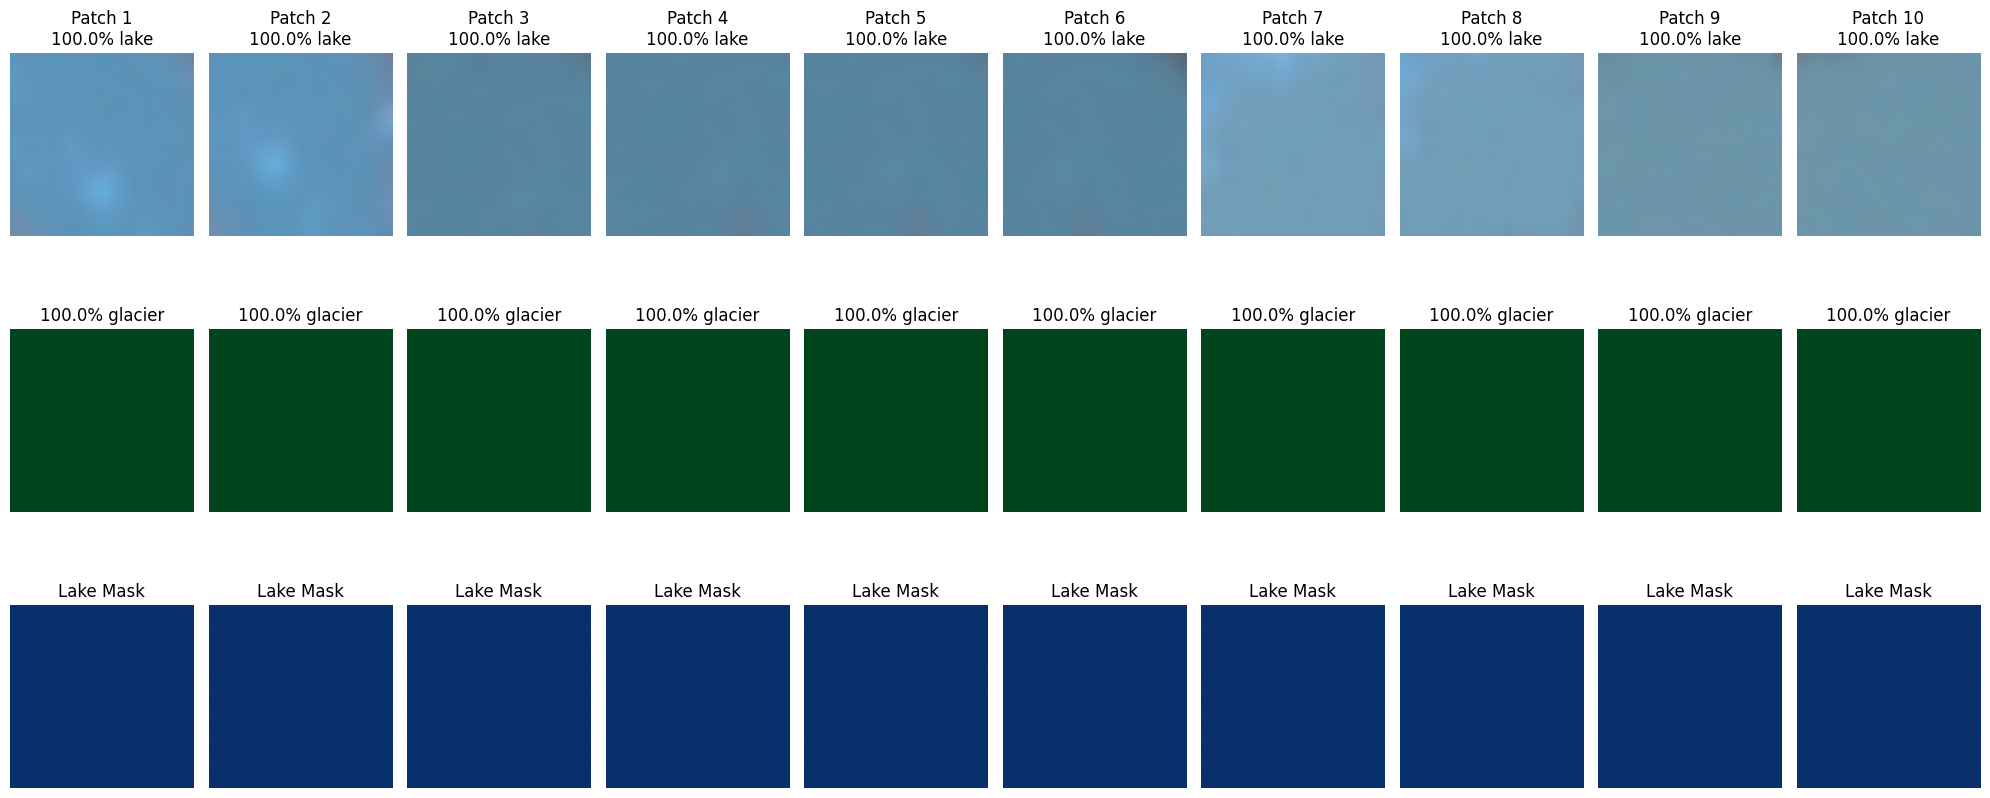

In [6]:
# Visualize glacier-constrained dataset patches
def visualize_glacier_dataset(dataset, num_patches=8):
    fig, axes = plt.subplots(3, num_patches, figsize=(20, 9))
    
    for i in range(min(num_patches, len(dataset))):
        # Get patch and mask
        image_tensor, mask_tensor = dataset[i]
        patch_info = dataset.patch_info[i]
        
        # Convert back to numpy for visualization
        img = image_tensor.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1).numpy()
        
        mask = mask_tensor.squeeze().numpy()
        
        # Get original patches for glacier visualization (use actual patch size)
        y, x = patch_info['y'], patch_info['x']
        patch_size = dataset.patch_size  # Use dataset's patch size
        glacier_patch = glacier_mask[y:y+patch_size, x:x+patch_size]
        
        # Plot image - fix the f-string
        patch_title = f'Patch {i+1}\n{patch_info["lake_coverage"]:.1%} lake'
        axes[0, i].imshow(img)
        axes[0, i].set_title(patch_title)
        axes[0, i].axis('off')
        
        # Plot glacier mask
        axes[1, i].imshow(glacier_patch, cmap='Greens', vmin=0, vmax=1)
        axes[1, i].set_title(f'{patch_info["glacier_coverage"]:.1%} glacier')
        axes[1, i].axis('off')
        
        # Plot lake mask
        axes[2, i].imshow(mask, cmap='Blues', vmin=0, vmax=1)
        axes[2, i].set_title(f'Lake Mask')
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('RGB Image', rotation=90, size=12)
    axes[1, 0].set_ylabel('Glacier Mask', rotation=90, size=12)
    axes[2, 0].set_ylabel('Lake Mask', rotation=90, size=12)
    
    plt.tight_layout()
    plt.show()

# Visualize the glacier-constrained dataset
print("Visualizing glacier-constrained dataset patches...")
visualize_glacier_dataset(glacier_dataset, num_patches=10)

## Step 6: Define DINOv3 + U-Net Model

In [7]:
class DynamicUNetDecoder(nn.Module):
    """
    Dynamic U-Net decoder that outputs 224x224 to match DINOv3 expectations
    """
    def __init__(self, feature_dim=768, num_classes=1, target_size=224):
        super(DynamicUNetDecoder, self).__init__()
        self.target_size = target_size
        
        # Adaptive upsampling layers
        self.conv1 = nn.Conv2d(feature_dim, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Apply convolutions
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.final(x)
        
        # Always resize to 224x224 for training compatibility
        x = nn.functional.interpolate(x, size=(self.target_size, self.target_size), mode='bilinear', align_corners=False)
        
        x = self.sigmoid(x)
        return x


class GlacierDINOv3UNet(nn.Module):
    """
    Complete model: DINOv3 backbone + U-Net decoder for glacier-constrained segmentation
    """
    def __init__(self, original_patch_size=20):  # Changed to 20x20
        super(GlacierDINOv3UNet, self).__init__()
        
        # Store original patch size for later use
        self.original_patch_size = original_patch_size
        
        # Load DINOv3 model
        self.dinov3 = AutoModel.from_pretrained("facebook/dinov3-vitb16-pretrain-lvd1689m")
        
        # Freeze DINOv3 parameters (use as feature extractor only)
        for param in self.dinov3.parameters():
            param.requires_grad = False
        
        # U-Net decoder - always outputs 224x224 during training
        self.decoder = DynamicUNetDecoder(feature_dim=768, target_size=224)
        
        print(f"Model created: Glacier-constrained DINOv3 (frozen) + U-Net decoder (trainable)")
        print(f"Training: 224x224 → 224x224, Inference: 224x224 → {original_patch_size}x{original_patch_size}")
    
    def forward(self, x, resize_output=False, target_size=None):
        # Extract features with DINOv3
        with torch.no_grad():
            features = self.dinov3(x).last_hidden_state
            
            # Remove CLS token
            patch_features = features[:, 1:]
            
            # Calculate spatial dimensions
            batch_size, num_patches, feature_dim = patch_features.shape
            
            # Find best spatial dimensions
            possible_dims = []
            for h in range(1, num_patches + 1):
                if num_patches % h == 0:
                    w = num_patches // h
                    possible_dims.append((h, w))
            
            if possible_dims:
                h, w = min(possible_dims, key=lambda dims: abs(dims[0] - dims[1]))
            else:
                h = int(num_patches**0.5)
                w = int(num_patches**0.5)
            
            # Handle dimension mismatch
            if h * w != num_patches:
                needed_patches = h * w
                if needed_patches > num_patches:
                    padding = torch.zeros(batch_size, needed_patches - num_patches, feature_dim, device=patch_features.device)
                    patch_features = torch.cat([patch_features, padding], dim=1)
                else:
                    patch_features = patch_features[:, :needed_patches]
            
            # Reshape to 2D feature map
            feature_map = patch_features.reshape(batch_size, h, w, feature_dim)
            feature_map = feature_map.permute(0, 3, 1, 2)
        
        # Generate segmentation mask (224x224)
        mask = self.decoder(feature_map)
        
        # Optionally resize output (for inference)
        if resize_output and target_size is not None:
            mask = nn.functional.interpolate(mask, size=(target_size, target_size), mode='bilinear', align_corners=False)
        
        return mask

# Create model for 20x20 patches
glacier_model = GlacierDINOv3UNet(original_patch_size=20).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(glacier_model.decoder.parameters(), lr=0.001)

print(f"Model parameters: {sum(p.numel() for p in glacier_model.parameters() if p.requires_grad):,}")

Model created: Glacier-constrained DINOv3 (frozen) + U-Net decoder (trainable)
Training: 224x224 → 224x224, Inference: 224x224 → 20x20
Model parameters: 5,088,257


## Step 7: Train Glacier-Constrained Model

In [ ]:
# Training function
def train_glacier_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    
    print("Starting glacier-constrained training...")
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx == 0:  # Print for first batch of each epoch
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')
        
        avg_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}\n')
    
    print("Glacier-constrained training completed!")

# Train the model
train_glacier_model(glacier_model, glacier_dataloader, criterion, optimizer, num_epochs=5)

## Step 8: Test and Visualize Results

In [ ]:
# Test the glacier-constrained model
glacier_model.eval()

# Get a batch of test data
test_images, test_masks = next(iter(glacier_dataloader))
test_images = test_images.to(device)

# Generate predictions
with torch.no_grad():
    predicted_masks = glacier_model(test_images)

# Move to CPU for visualization
test_images = test_images.cpu()
test_masks = test_masks.cpu()
predicted_masks = predicted_masks.cpu()

# Visualize results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(min(4, len(test_images))):
    # Original image (denormalize for display)
    img = test_images[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Glacier Image {i+1}')
    axes[0, i].axis('off')
    
    # Ground truth mask
    axes[1, i].imshow(test_masks[i].squeeze(), cmap='Blues')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    axes[1, i].axis('off')
    
    # Predicted mask
    pred_mask = predicted_masks[i].squeeze()
    axes[2, i].imshow(pred_mask, cmap='Reds')
    axes[2, i].set_title(f'Prediction {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy metrics
def calculate_metrics(pred_masks, true_masks, threshold=0.5):
    pred_binary = (pred_masks > threshold).float()
    
    intersection = (pred_binary * true_masks).sum()
    union = pred_binary.sum() + true_masks.sum() - intersection
    
    iou = intersection / (union + 1e-8)
    accuracy = ((pred_binary == true_masks).float().mean())
    
    return iou.item(), accuracy.item()

iou, accuracy = calculate_metrics(predicted_masks, test_masks)
print(f"\nGlacier-Constrained Model Performance:")
print(f"IoU (Intersection over Union): {iou:.3f}")
print(f"Pixel Accuracy: {accuracy:.3f}")

## Step 9: Full Image Prediction with Glacier Constraints

In [ ]:
def predict_glacier_constrained_image(model, image, glacier_mask, patch_size=65, stride=56, max_size=1000):
    """
    Apply model predictions only within glacier boundaries
    Handles 20x20 patches with 50% overlap (stride=10) for better small lake detection
    """
    print("Generating glacier-constrained full image prediction...")
    
    model.eval()
    
    # Use subset if image is too large
    height, width = image.shape[:2]
    if height > max_size or width > max_size:
        h_crop = min(height, max_size)
        w_crop = min(width, max_size)
        image_crop = image[:h_crop, :w_crop]
        glacier_mask_crop = glacier_mask[:h_crop, :w_crop]
        print(f"Using {h_crop}x{w_crop} subset for visualization")
    else:
        image_crop = image
        glacier_mask_crop = glacier_mask
    
    height, width = image_crop.shape[:2]
    
    # Initialize prediction mask
    full_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)
    
    # Transform that matches training (resize to 224x224 for DINOv3)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to DINOv3 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    patches_processed = 0
    glacier_patches_processed = 0
    
    print(f"Processing patches of size {patch_size}x{patch_size} with stride {stride} (50% overlap)")
    
    with torch.no_grad():
        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                # Check if patch has sufficient glacier coverage
                patch_glacier_mask = glacier_mask_crop[y:y+patch_size, x:x+patch_size]
                glacier_coverage = patch_glacier_mask.sum() / (patch_size * patch_size)
                
                if glacier_coverage > 0.3:  # Only process patches with >30% glacier
                    try:
                        # Extract patch (only RGB channels)
                        patch = image_crop[y:y+patch_size, x:x+patch_size, :3].copy()
                        
                        # Zero out non-glacier areas in patch
                        patch[~patch_glacier_mask] = 0
                        
                        # Transform patch (resize to 224x224 for DINOv3)
                        patch_tensor = transform(patch).unsqueeze(0).to(device)
                        
                        # Get prediction (224x224 output from model)
                        pred_mask_224 = model(patch_tensor).squeeze().cpu().numpy()
                        
                        # Resize prediction back to original patch size (20x20)
                        pred_mask_pil = Image.fromarray((pred_mask_224 * 255).astype(np.uint8))
                        pred_mask_resized = pred_mask_pil.resize((patch_size, patch_size), Image.BILINEAR)
                        pred_mask = np.array(pred_mask_resized) / 255.0
                        
                        # Only apply prediction within glacier areas
                        pred_mask = pred_mask * patch_glacier_mask.astype(float)
                        
                        # Add to full mask
                        full_mask[y:y+patch_size, x:x+patch_size] += pred_mask
                        count_mask[y:y+patch_size, x:x+patch_size] += patch_glacier_mask.astype(float)
                        
                        glacier_patches_processed += 1
                        
                    except Exception as e:
                        print(f"Error processing patch at ({y}, {x}): {e}")
                        continue
                
                patches_processed += 1
                
                # Progress update
                if patches_processed % 500 == 0:  # More frequent updates due to more patches
                    print(f"  Processed {patches_processed} patches, {glacier_patches_processed} on glacier")
    
    # Average overlapping predictions
    predicted_mask = np.divide(full_mask, count_mask, out=np.zeros_like(full_mask), where=count_mask>0)
    
    print(f"Completed! Processed {patches_processed} total patches")
    print(f"Processed {glacier_patches_processed} glacier patches")
    print(f"Final prediction shape: {predicted_mask.shape}")
    print(f"Average overlap per pixel: {count_mask[count_mask>0].mean():.1f}")
    
    return predicted_mask, image_crop, glacier_mask_crop

# Test with a smaller area first to debug
print("Testing prediction on small area with 20x20 patches and stride=10...")

# Use just a 500x500 area for testing
test_size = 500
test_image = image_rgb[:test_size, :test_size]
test_glacier_mask = glacier_mask[:test_size, :test_size]

try:
    # Generate glacier-constrained prediction with 20x20 patches and 50% overlap
    glacier_prediction, cropped_image, cropped_glacier_mask = predict_glacier_constrained_image(
        glacier_model, test_image, test_glacier_mask, patch_size=20, stride=10, max_size=test_size
    )
    
    print("\nPrediction successful! Visualizing results...")
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original image
    axes[0, 0].imshow(cropped_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Glacier mask
    axes[0, 1].imshow(cropped_glacier_mask, cmap='Greens', alpha=0.8)
    axes[0, 1].set_title('Glacier Constraint Mask')
    axes[0, 1].axis('off')
    
    # Ground truth lakes
    cropped_lake_mask = lake_mask_binary[:cropped_image.shape[0], :cropped_image.shape[1]]
    axes[1, 0].imshow(cropped_lake_mask, cmap='Blues', alpha=0.8)
    axes[1, 0].set_title('Ground Truth Lakes')
    axes[1, 0].axis('off')
    
    # DINOv3 prediction
    axes[1, 1].imshow(glacier_prediction, cmap='Reds', alpha=0.8)
    axes[1, 1].set_title('20x20 Patch Prediction (50% Overlap)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    pred_binary = (glacier_prediction > 0.5).astype(float)
    true_binary = cropped_lake_mask.astype(float)
    
    intersection = (pred_binary * true_binary).sum()
    union = pred_binary.sum() + true_binary.sum() - intersection
    iou = intersection / (union + 1e-8)
    
    print(f"\nTest Results with 20x20 patches:")
    print(f"IoU: {iou:.3f}")
    print(f"True lake pixels: {true_binary.sum():.0f}")
    print(f"Predicted lake pixels: {pred_binary.sum():.0f}")
    
except Exception as e:
    print(f"Prediction failed: {e}")
    import traceback
    traceback.print_exc()

## Summary

**Glacier-Constrained Lake Detection Pipeline:**

1. **Glacier Shapefile Integration** - Uses RGI or custom glacier boundaries
2. **Smart Sampling** - Only trains on patches within glacier areas
3. **Focused Training** - Model learns glacier-specific lake patterns
4. **Constrained Prediction** - Applies detection only within glacier boundaries
5. **Accurate Results** - Eliminates false positives from non-glacial terrain

**Key Advantages:**
- Eliminates irrelevant background terrain
- Focuses computational resources on relevant areas
- Improves training data quality
- Reduces false positives
- Maintains spatial context within glacier boundaries

**Next Steps:**
- Apply to full time series data
- Test different glacier coverage thresholds
- Compare results with unconstrained approach
- Validate against field observations